INSTALLING LIBRARIES FOR TRAINING SUPERVISED CONTRASTIVE LEARNING MODEL

In [ ]:
!pip install scikit-learn tqdm --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from PIL import Image
import matplotlib.pyplot as plt


EXTRACTING DATA

In [ ]:
import zipfile

zip_file = '/content/openaimer-2025-track1.zip'  # Adjust this if needed (e.g., if your zip file has a different name)

# Unzip the file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Verify extraction
print(os.listdir('/content/'))

['.config', 'sample_submission.csv', 'openaimer-2025-track1.zip', 'OpenAImer2025_Image_Classification', 'sample_data']


RANDOM STRATIFIED SPLITTING OF DATASET FOR EACH EPOCH

In [ ]:
def get_stratified_split(dataset, test_size=0.2, random_state=None):
    labels = [sample[1] for sample in dataset.samples]
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)

    for train_indices, val_indices in splitter.split(np.zeros(len(labels)), labels):
        train_subset = Subset(dataset, train_indices)
        val_subset = Subset(dataset, val_indices)

    return train_subset, val_subset

DATA TRANSFORM TTA + NORMAL

In [ ]:
train_data_path = '/content/OpenAImer2025_Image_Classification/OpenAImer/train'

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

tta_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.TenCrop(224),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    transforms.Lambda(lambda crops: torch.stack([
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])(crop) for crop in crops
    ]))
])

train_dataset = datasets.ImageFolder(root=train_data_path, transform=transform_train)


LOADING DATA

In [ ]:
def get_data_loaders(batch_size=32):
    train_subset, val_subset = get_stratified_split(train_dataset, test_size=0.2)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader


DEFINING CONTRASTIVE ENCODER MODEL

In [ ]:
encoder = models.resnet18(pretrained=True)
num_features = encoder.fc.in_features
encoder.fc = nn.Identity()

class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        features = nn.functional.normalize(features, p=2, dim=1)
        similarity_matrix = torch.matmul(features, features.T)
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float()
        exp_sim = torch.exp(similarity_matrix / self.temperature)
        exp_sim = exp_sim * (1 - torch.eye(len(labels)).to(features.device))
        loss = -torch.log((exp_sim * mask).sum(1) / exp_sim.sum(1) + 1e-9)
        return loss.mean()

PRE TRAINING OF ENCODERS WITH DIFFERENT STRATIFIED DATASET SPLITTING FOR EACH EPOCH

In [ ]:
optimizer_encoder = optim.Adam(encoder.parameters(), lr=1e-4)
criterion_encoder = SupConLoss()
num_epochs_encoder = 10

for epoch in range(num_epochs_encoder):
    train_loader, _ = get_data_loaders()
    encoder.train()
    total_loss = 0

    progress = tqdm(train_loader, desc=f"[Encoder] Epoch {epoch+1}/{num_epochs_encoder}")

    for images, labels in progress:
        optimizer_encoder.zero_grad()
        features = encoder(images)
        loss = criterion_encoder(features, labels)
        loss.backward()
        optimizer_encoder.step()
        total_loss += loss.item()
        progress.set_postfix(loss=total_loss / (progress.n + 1))

[Encoder] Epoch 10/10: 100%|██████████| 77/77 [05:51<00:00,  4.57s/it, loss=0.812]


DEFINING CLASSIFIER HEAD MODEL

In [ ]:
class ClassifierHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClassifierHead, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

num_classes = len(train_dataset.classes)
head = ClassifierHead(input_dim=num_features, num_classes=num_classes)

TRAINING OF CLASSIFIER HEAD WITH DIFFERENT  STRATIFIED DATASET SPLITTING FOR EACH EPOCH

In [ ]:
optimizer_head = optim.Adam(head.parameters(), lr=1e-4)
criterion_head = nn.CrossEntropyLoss()
num_epochs_head = 10

for epoch in range(num_epochs_head):
    train_loader, val_loader = get_data_loaders()
    encoder.eval()
    head.train()
    total_loss = 0
    all_preds, all_labels = [], []

    progress = tqdm(train_loader, desc=f"[Head] Epoch {epoch+1}/{num_epochs_head}")

    for images, labels in progress:
        optimizer_head.zero_grad()
        with torch.no_grad():
            features = encoder(images)
        outputs = head(features)
        loss = criterion_head(outputs, labels)
        loss.backward()
        optimizer_head.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        progress.set_postfix(loss=total_loss / (progress.n + 1))

    train_acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    train_f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.4f}")


[Head] Epoch 1/10: 100%|██████████| 77/77 [02:06<00:00,  1.64s/it, loss=1.23]


Train Acc: 64.13%, Train F1: 0.6130


[Head] Epoch 2/10: 100%|██████████| 77/77 [02:05<00:00,  1.64s/it, loss=0.406]


Train Acc: 92.81%, Train F1: 0.9131


[Head] Epoch 3/10: 100%|██████████| 77/77 [02:06<00:00,  1.64s/it, loss=0.26]


Train Acc: 95.44%, Train F1: 0.9529


[Head] Epoch 4/10: 100%|██████████| 77/77 [02:08<00:00,  1.66s/it, loss=0.185]


Train Acc: 96.67%, Train F1: 0.9666


[Head] Epoch 5/10: 100%|██████████| 77/77 [02:07<00:00,  1.65s/it, loss=0.15]


Train Acc: 96.96%, Train F1: 0.9696


[Head] Epoch 6/10: 100%|██████████| 77/77 [02:06<00:00,  1.64s/it, loss=0.133]


Train Acc: 97.17%, Train F1: 0.9716


[Head] Epoch 7/10: 100%|██████████| 77/77 [02:07<00:00,  1.66s/it, loss=0.116]


Train Acc: 97.00%, Train F1: 0.9700


[Head] Epoch 8/10: 100%|██████████| 77/77 [02:08<00:00,  1.67s/it, loss=0.119]


Train Acc: 97.33%, Train F1: 0.9733


[Head] Epoch 9/10: 100%|██████████| 77/77 [02:06<00:00,  1.64s/it, loss=0.0992]


Train Acc: 97.33%, Train F1: 0.9733


[Head] Epoch 10/10: 100%|██████████| 77/77 [02:08<00:00,  1.67s/it, loss=0.106]

Train Acc: 97.12%, Train F1: 0.9712


SAVING THE MODEL

In [ ]:
# Save both Encoder and Head after training
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'head_state_dict': head.state_dict(),
}, 'contrastive_model.pth')

print("✅ Model saved as contrastive_model.pth")


✅ Model saved as contrastive_model.pth


VALIDATI0N F1 WITH TTA

In [ ]:
encoder.eval()
head.eval()

tta_dataset = datasets.ImageFolder(root=train_data_path, transform=tta_transform)
_, val_subset = get_stratified_split(tta_dataset, test_size=0.2)
val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Validating (TTA)"):
        images = images.squeeze(0)
        features = encoder(images)
        outputs = head(features)
        outputs = outputs.mean(dim=0, keepdim=True)
        _, predicted = torch.max(outputs, 1)

        all_preds.append(predicted.cpu().numpy()[0])
        all_labels.append(labels.item())

val_acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
val_f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"[Validation TTA] Accuracy: {val_acc:.2f}% | F1 Score: {val_f1:.4f}")


APPLYING THE MODEL ON TEST DATA AND SAVING AS CSV

In [ ]:
test_data_path = '/content/OpenAImer2025_Image_Classification/OpenAImer/test'

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

class UnlabeledDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('png', 'jpg', 'jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        image_id = os.path.basename(self.image_paths[idx])
        return image, image_id

test_dataset = UnlabeledDataset(test_data_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

results = []

encoder.eval()
head.eval()

with torch.no_grad():
    for images, image_ids in tqdm(test_loader, desc="Predicting Test Set"):
        features = encoder(images)
        outputs = head(features)
        _, predicted = torch.max(outputs, 1)
        results.append((image_ids[0], predicted.cpu().numpy()[0]))

df = pd.DataFrame(results, columns=['id', 'label'])
df.to_csv('test_predictionshope.csv', index=False)
print("Predictions saved to 'test_predictionshope.csv'.")


Predicting Test Set: 100%|██████████| 1401/1401 [02:14<00:00, 10.41it/s]

Predictions saved to 'test_predictionshope.csv'.


In [ ]:
import torch

checkpoint = torch.load('/content/contrastive_model.pth', map_location='cpu')
print(checkpoint.keys())


dict_keys(['encoder_state_dict', 'head_state_dict'])


LOADING SAVED MODEL AND APPLYING ON TEST DATA

✅ Encoder loaded.
Missing keys: []
Unexpected keys: []
✅ Head state_dict loaded successfully.


Predicting Test Set: 100%|██████████| 1401/1401 [02:10<00:00, 10.70it/s]


✅ Predictions saved to 'test_predictions_fixed.csv'.


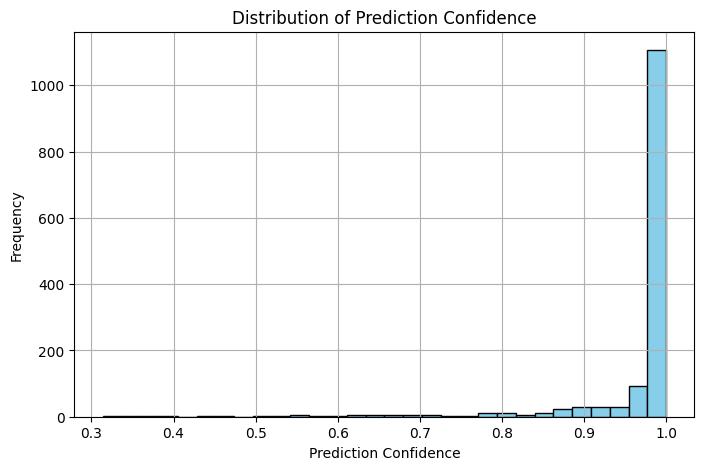

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
import os
import pandas as pd
import matplotlib.pyplot as plt

# === Define model ===
encoder = models.resnet18(pretrained=False)
encoder.fc = torch.nn.Identity()  # remove final FC for feature extraction
head = torch.nn.Linear(512, 7)    # correct number of classes!

# === Load the saved weights ===
checkpoint = torch.load('/content/contrastive_model.pth', map_location='cpu')

# Load encoder state_dict
missing, unexpected = encoder.load_state_dict(checkpoint['encoder_state_dict'], strict=False)
print(f"✅ Encoder loaded.\nMissing keys: {missing}\nUnexpected keys: {unexpected}")

# Fix head keys if saved as fc.*
if 'head_state_dict' in checkpoint:
    fc_state_dict = checkpoint['head_state_dict']
    corrected_state_dict = {k.replace('fc.', ''): v for k, v in fc_state_dict.items()}
    head.load_state_dict(corrected_state_dict)
    print("✅ Head state_dict loaded successfully.")
else:
    print("⚠️ Warning: head_state_dict not found in checkpoint!")

encoder.eval()
head.eval()

# === Dataset Setup ===
test_data_path = '/content/OpenAImer2025_Image_Classification/OpenAImer/test'

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

class UnlabeledDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                            if f.lower().endswith(('png', 'jpg', 'jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        image_id = os.path.basename(self.image_paths[idx])
        return image, image_id

test_dataset = UnlabeledDataset(test_data_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# === Predict without TTA ===
results = []

with torch.no_grad():
    for images, image_ids in tqdm(test_loader, desc="Predicting Test Set"):
        features = encoder(images)                # [1, 512]
        outputs = head(features)                  # [1, 7]
        probs = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probs, 1)
        results.append((image_ids[0], predicted.cpu().item(), confidence.cpu().item()))

# === Save Predictions ===
df = pd.DataFrame(results, columns=['id', 'label', 'confidence'])
df.to_csv('test_predictions_fixed.csv', index=False)
print("✅ Predictions saved to 'test_predictions_fixed.csv'.")

# === Plot Confidence Distribution ===
plt.figure(figsize=(8, 5))
plt.hist([c for _, _, c in results], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Confidence')
plt.grid(True)
plt.show()


APPLYING TTA WHEN MODEL PREDICTION FALLS UNDER THRESHOLD

✅ Encoder loaded.
Missing keys: []
Unexpected keys: []
✅ Head state_dict loaded successfully.


Predicting Test Set: 100%|██████████| 1401/1401 [06:06<00:00,  3.82it/s]


✅ Predictions saved to 'test_predictions_with_tta.csv'.


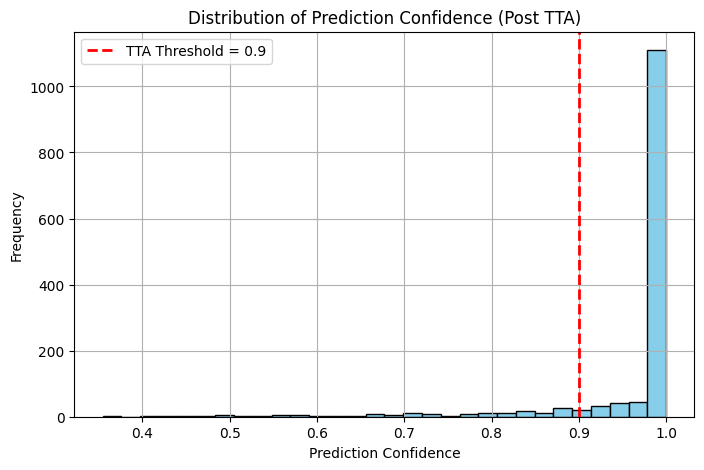

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
import os
import pandas as pd
import matplotlib.pyplot as plt

# === Define model ===
encoder = models.resnet18(pretrained=False)
encoder.fc = torch.nn.Identity()  # remove final FC for feature extraction
head = torch.nn.Linear(512, 7)    # correct number of classes!

# === Load the saved weights ===
checkpoint = torch.load('/content/contrastive_model.pth', map_location='cpu')

# Load encoder state_dict
missing, unexpected = encoder.load_state_dict(checkpoint['encoder_state_dict'], strict=False)
print(f"✅ Encoder loaded.\nMissing keys: {missing}\nUnexpected keys: {unexpected}")

# Fix head keys if saved as fc.*
if 'head_state_dict' in checkpoint:
    fc_state_dict = checkpoint['head_state_dict']
    corrected_state_dict = {k.replace('fc.', ''): v for k, v in fc_state_dict.items()}
    head.load_state_dict(corrected_state_dict)
    print("✅ Head state_dict loaded successfully.")
else:
    print("⚠️ Warning: head_state_dict not found in checkpoint!")

encoder.eval()
head.eval()

# === Dataset Setup ===
test_data_path = '/content/OpenAImer2025_Image_Classification/OpenAImer/test'

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

class UnlabeledDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                            if f.lower().endswith(('png', 'jpg', 'jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        image_id = os.path.basename(self.image_paths[idx])
        return image, image_id

test_dataset = UnlabeledDataset(test_data_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# === TTA transform ===
tta_base_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.TenCrop(224),  # returns tuple of 10 PIL Images
    transforms.Lambda(lambda crops: torch.stack([
        transforms.ToTensor()(crop) for crop in crops
    ])),
    transforms.Lambda(lambda crops: torch.stack([
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])(crop) for crop in crops
    ]))
])

# === Predict with TTA fallback ===
results = []

with torch.no_grad():
    for images, image_ids in tqdm(test_loader, desc="Predicting Test Set"):
        features = encoder(images)                # [1, 512]
        outputs = head(features)                  # [1, 7]
        probs = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probs, 1)

        if confidence.item() < 0.98:
            image = Image.open(os.path.join(test_data_path, image_ids[0])).convert('RGB')
            tta_images = tta_base_transform(image)  # [10, 3, 224, 224]

            tta_features = encoder(tta_images)     # [10, 512]
            tta_outputs = head(tta_features)       # [10, 7]

            tta_probs = F.softmax(tta_outputs, dim=1).mean(dim=0, keepdim=True)  # [1, 7]
            confidence, predicted = torch.max(tta_probs, 1)

        results.append((image_ids[0], predicted.cpu().item(), confidence.cpu().item()))

# === Save Predictions ===
df = pd.DataFrame(results, columns=['id', 'label', 'confidence'])
df.to_csv('test_predictions_with_tta.csv', index=False)
print("✅ Predictions saved to 'test_predictions_with_tta.csv'.")

# === Plot Confidence Distribution ===
plt.figure(figsize=(8, 5))
plt.hist([c for _, _, c in results], bins=30, color='skyblue', edgecolor='black')
plt.axvline(0.9, color='red', linestyle='dashed', linewidth=2, label='TTA Threshold = 0.9')
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Confidence (Post TTA)')
plt.legend()
plt.grid(True)
plt.show()


APPLYING  TTA  ON COMPLETE TEST DATA

✅ Encoder loaded.
Missing keys: []
Unexpected keys: []
✅ Head state_dict loaded successfully.


Predicting with TTA: 100%|██████████| 1401/1401 [17:35<00:00,  1.33it/s]

✅ Full TTA Predictions saved to 'test_predictions_tta_only.csv'.


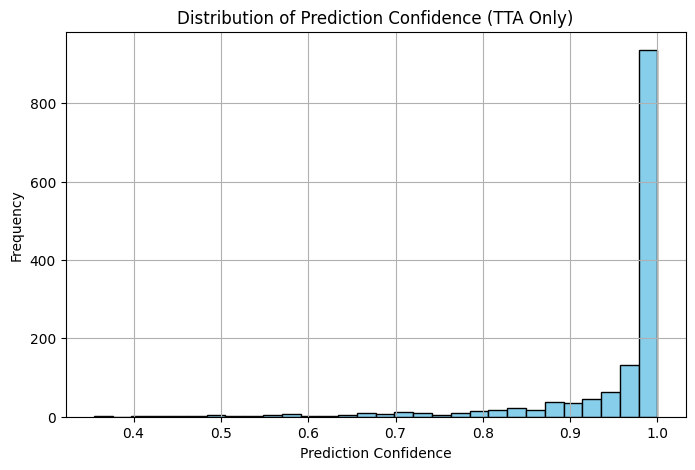

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
import os
import pandas as pd
import matplotlib.pyplot as plt

# === Define model ===
encoder = models.resnet18(pretrained=False)
encoder.fc = torch.nn.Identity()  # Remove final FC layer
head = torch.nn.Linear(512, 7)    # 7 classes!

# === Load the saved weights ===
checkpoint = torch.load('/content/contrastive_model.pth', map_location='cpu')

# Encoder weights
missing, unexpected = encoder.load_state_dict(checkpoint['encoder_state_dict'], strict=False)
print(f"✅ Encoder loaded.\nMissing keys: {missing}\nUnexpected keys: {unexpected}")

# Head weights
if 'head_state_dict' in checkpoint:
    fc_state_dict = checkpoint['head_state_dict']
    corrected_state_dict = {k.replace('fc.', ''): v for k, v in fc_state_dict.items()}
    head.load_state_dict(corrected_state_dict)
    print("✅ Head state_dict loaded successfully.")
else:
    print("⚠️ Warning: head_state_dict not found in checkpoint!")

encoder.eval()
head.eval()

# === Dataset Setup ===
test_data_path = '/content/OpenAImer2025_Image_Classification/OpenAImer/test'

test_image_paths = [os.path.join(test_data_path, f) for f in os.listdir(test_data_path)
                    if f.lower().endswith(('png', 'jpg', 'jpeg'))]

# === TTA transform (always applied) ===
tta_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.TenCrop(224),  # returns tuple of 10 PIL Images
    transforms.Lambda(lambda crops: torch.stack([
        transforms.ToTensor()(crop) for crop in crops
    ])),
    transforms.Lambda(lambda crops: torch.stack([
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])(crop) for crop in crops
    ]))
])

results = []

# === Predict with TTA applied to all ===
with torch.no_grad():
    for path in tqdm(test_image_paths, desc="Predicting with TTA"):
        image = Image.open(path).convert('RGB')
        tta_images = tta_transform(image)  # [10, 3, 224, 224]

        tta_features = encoder(tta_images)     # [10, 512]
        tta_outputs = head(tta_features)       # [10, 7]

        tta_probs = F.softmax(tta_outputs, dim=1).mean(dim=0, keepdim=True)  # [1, 7]
        confidence, predicted = torch.max(tta_probs, 1)

        image_id = os.path.basename(path)
        results.append((image_id, predicted.cpu().item(), confidence.cpu().item()))

# === Save Predictions ===
df = pd.DataFrame(results, columns=['id', 'label', 'confidence'])
df.to_csv('test_predictions_tta_only.csv', index=False)
print("✅ Full TTA Predictions saved to 'test_predictions_tta_only.csv'.")

# === Plot Confidence Distribution ===
plt.figure(figsize=(8, 5))
plt.hist([c for _, _, c in results], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Confidence (TTA Only)')
plt.grid(True)
plt.show()
